In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from gate_simulation.macrotools import *
from gate_simulation.analysis import *

# Simulation of the proton beam tracker/calorimeter

> This project will have tools to aid a simulation and optimizatin of the proton beam tracker/calorimeter in application for determining the corrections to the proton stopping powers for treatment planning.

![image.png](media/gate_simulation.png "Gate Simulation")

## Prerequisites

To use this package you need to first install:
* [root](https://root.cern/install/) 
* [Gate](http://www.opengatecollaboration.org)
    * I am using a version of Gate I cloned from [their Github](https://github.com/OpenGATE/Gate) page, because the official 9.0 verion has a bug.
* [Geant4](https://geant4.web.cern.ch/support/download)
    * Check the requirements for the correct verion of Geant4 on [OpenGate](http://www.opengatecollaboration.org) page
* [Cmake](https://cmake.org/download/)

## Install

**Not working yet**

~~`pip install gate_simulation`~~

## How to use

Initiate a macro writer:

In [ ]:
test_macro = MacroWriter()

Create a macro:

In [ ]:
def create_all(n_phantom_layers = 5, phantom_layer_thickness = 1, phantom_material = 'Water', 
               distance_to_system = 1, system_thickness = 1, n_sensors = 1, sensor_pitch = 0.5, sensor_thickness=0.5):
    """sets parameters for phantom and system geometries"""
    phantom_thickness = n_phantom_layers * phantom_layer_thickness
    system_thickness = (sensor_thickness + sensor_pitch) * n_sensors
    # initialize an instance of MacroWriter
    my_macro = MacroWriter(system_y_loc=(-1)*phantom_thickness - distance_to_system, 
                           system_thickness=system_thickness)
    # create phantom layers
    for layer in range(n_phantom_layers):
        phantom_material = 'Water'
        # set material to Skull for the first and the last layer
        if layer == 0 or layer == n_phantom_layers - 1: 
            phantom_material = 'Skull'
        # layers start from 0 and extend in the negative y direction
        y_loc = (-1) * (phantom_layer_thickness * layer)
        my_macro.create_phantom_layer(n=layer, thickness=phantom_layer_thickness, y_loc=y_loc,
                                     material=phantom_material)
    for i_sensor in range(n_sensors):
        my_macro.create_sensor(n=i_sensor, y_loc= -(sensor_pitch + sensor_thickness) * i_sensor, 
                               thickness=sensor_thickness)
    return my_macro.create_macro_file()

In [ ]:
main_macro, output_root = create_all(n_sensors=3)

system thickness: 3.0
y location of sensor 0 is: 1.25
system created with: thickness: 3.0 at loc: -6
system thickness: 3.0
y location of sensor 1 is: 0.25
system thickness: 3.0
y location of sensor 2 is: -0.75


In [ ]:
run_macro(main_macro)

## The error on the mean versus sensor thickness
Sensor material is silicon.
The mean is the trimmed mean the upper limit is twice the standard deviation from the untrimmed mean.

In [ ]:
tm = []
etm = []
thicknesses = np.linspace(0.02, 1.0)
for t in thicknesses:
    main_macro, output_root = create_all(sensor_thickness=t)
    run_macro(main_macro)
    root_hits_file = output_root['hits'][0]
    edep = get_edep_data(root_hits_file)
    # check that edep exists
    if edep.any():
        tm.append(stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep))))
        etm.append(stats.tsem(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep))))
    else:
        print(f'No result for point {t}')
        # print(f'Trimmed mean {round(tm, 2)}, Error on trimmed mean: {round(etm, 2)}, SNR: {round(tm/etm, 2)}')

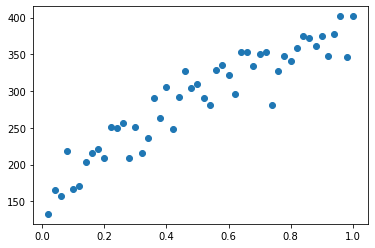

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(thicknesses, np.array(tm)/np.array(etm))

In [ ]:
import csv
columns = ["thickness", "trimmed mean", "error_on_trimmed_mean"]
with open('thickness.csv', 'w', encoding='utf-8') as f_out:
    f_writer = csv.writer(f_out, delimiter=',', lineterminator='\n')
    f_writer.writerow(columns)
    f_writer.writerows(zip(thicknesses, tm, etm))

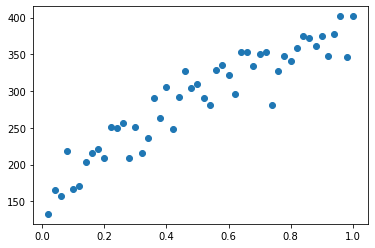

In [ ]:
import pandas
thickness_df = pandas.read_csv('thickness.csv')
# thickness_df.head()
plt.scatter(thickness_df['thickness'], thickness_df['trimmed mean']/thickness_df['error_on_trimmed_mean'])

In [ ]:
import numpy as np
from scipy import stats

m = np.mean(edep)
em = stats.sem(edep)
tm = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep)))
tm_p = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep) + em))
tm_m = stats.tmean(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep) - em))
etm = stats.tsem(edep, limits=(edep.min(),np.mean(edep) + 2 * np.std(edep)))
print(f'Mean:        {round(m,2)},       Error on mean: {round(em,2)}, SNR: {round(m/em, 2)}')
print(f'Trimmed mean {round(tm, 2)}, Error on trimmed mean: {round(etm, 2)}, SNR: {round(tm/etm, 2)}')
print(f'Trimmed mean upper {round(tm_p, 2)}, Trimmed mean lower {round(tm_m, 2)} difference: {round(tm_p - tm_m, 2)}, SNR: {round(tm/(tm_p - tm_m), 2)}')

#print(stats.mode(np.round(edep, 0)))

Mean:        181.66000366210938,       Error on mean: 2.4, SNR: 75.55
Trimmed mean 161.17, Error on trimmed mean: 0.66, SNR: 242.78
Trimmed mean upper 161.22, Trimmed mean lower 161.17 difference: 0.05, SNR: 3146.49


Recalculating the kinetic energy $E_k$ of the  particle mass  $M$ from its momentum $p$  according to:
$$E_k = \sqrt{M^2  + p^2} - M$$

In [ ]:
print(f'The kinetic energy of 2 GeV/c proton is {Ek(938,2000):.0f} MeV')

The kinetic energy of 2 GeV/c proton is 1271 MeV


In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_macro_tools.ipynb.
Converted 01_analysis.ipynb.
Converted 02_scanners.ipynb.
Converted index.ipynb.


In [ ]:
!ls mac

my_proton_beam.mac sensor1.mac        visu.mac
sensor0.mac        sensor2.mac
